In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
# читываем данные
df = pd.read_csv('ghana_gdp.zip', index_col= 'year', parse_dates=['year'])
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


<Axes: xlabel='year'>

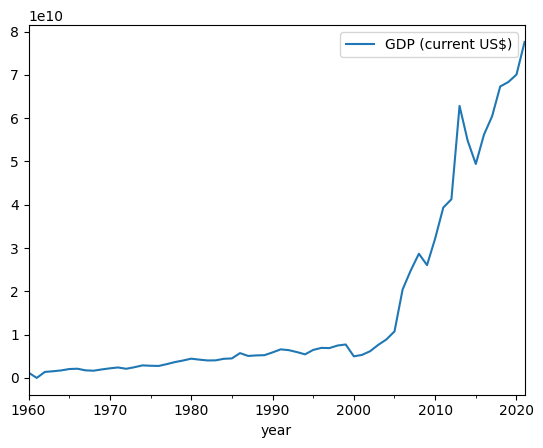

In [3]:
# визуализируем исходные данные 
df.plot()

In [4]:
# минимальное и максимальное значение индексов по годам
print(df.index.min())
print(df.index.max())

df.shape

1960-01-01 00:00:00
2021-01-01 00:00:00


(62, 1)

In [5]:
# делим данные на тестовую и тренировочную выборки
train_df = df.loc[:'2018-01-01']
test_df = df.loc['2019-01-01':]

train_df.shape , test_df.shape

((59, 1), (3, 1))

<Axes: xlabel='year'>

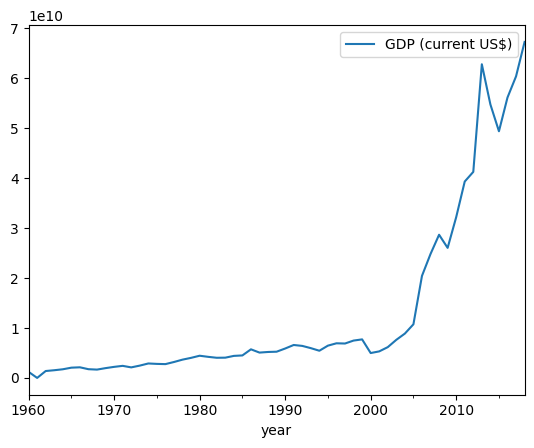

In [6]:
train_df.plot()

<Axes: xlabel='year'>

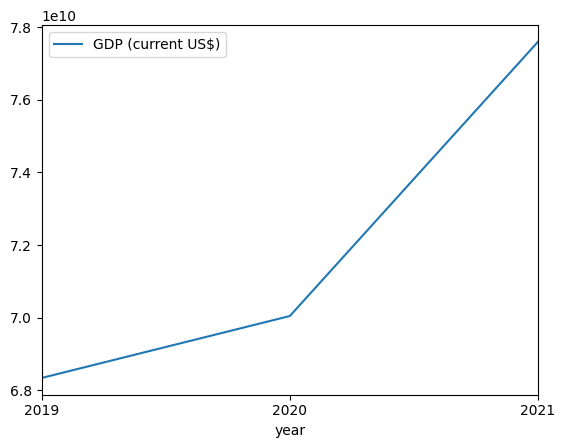

In [7]:
test_df.plot()

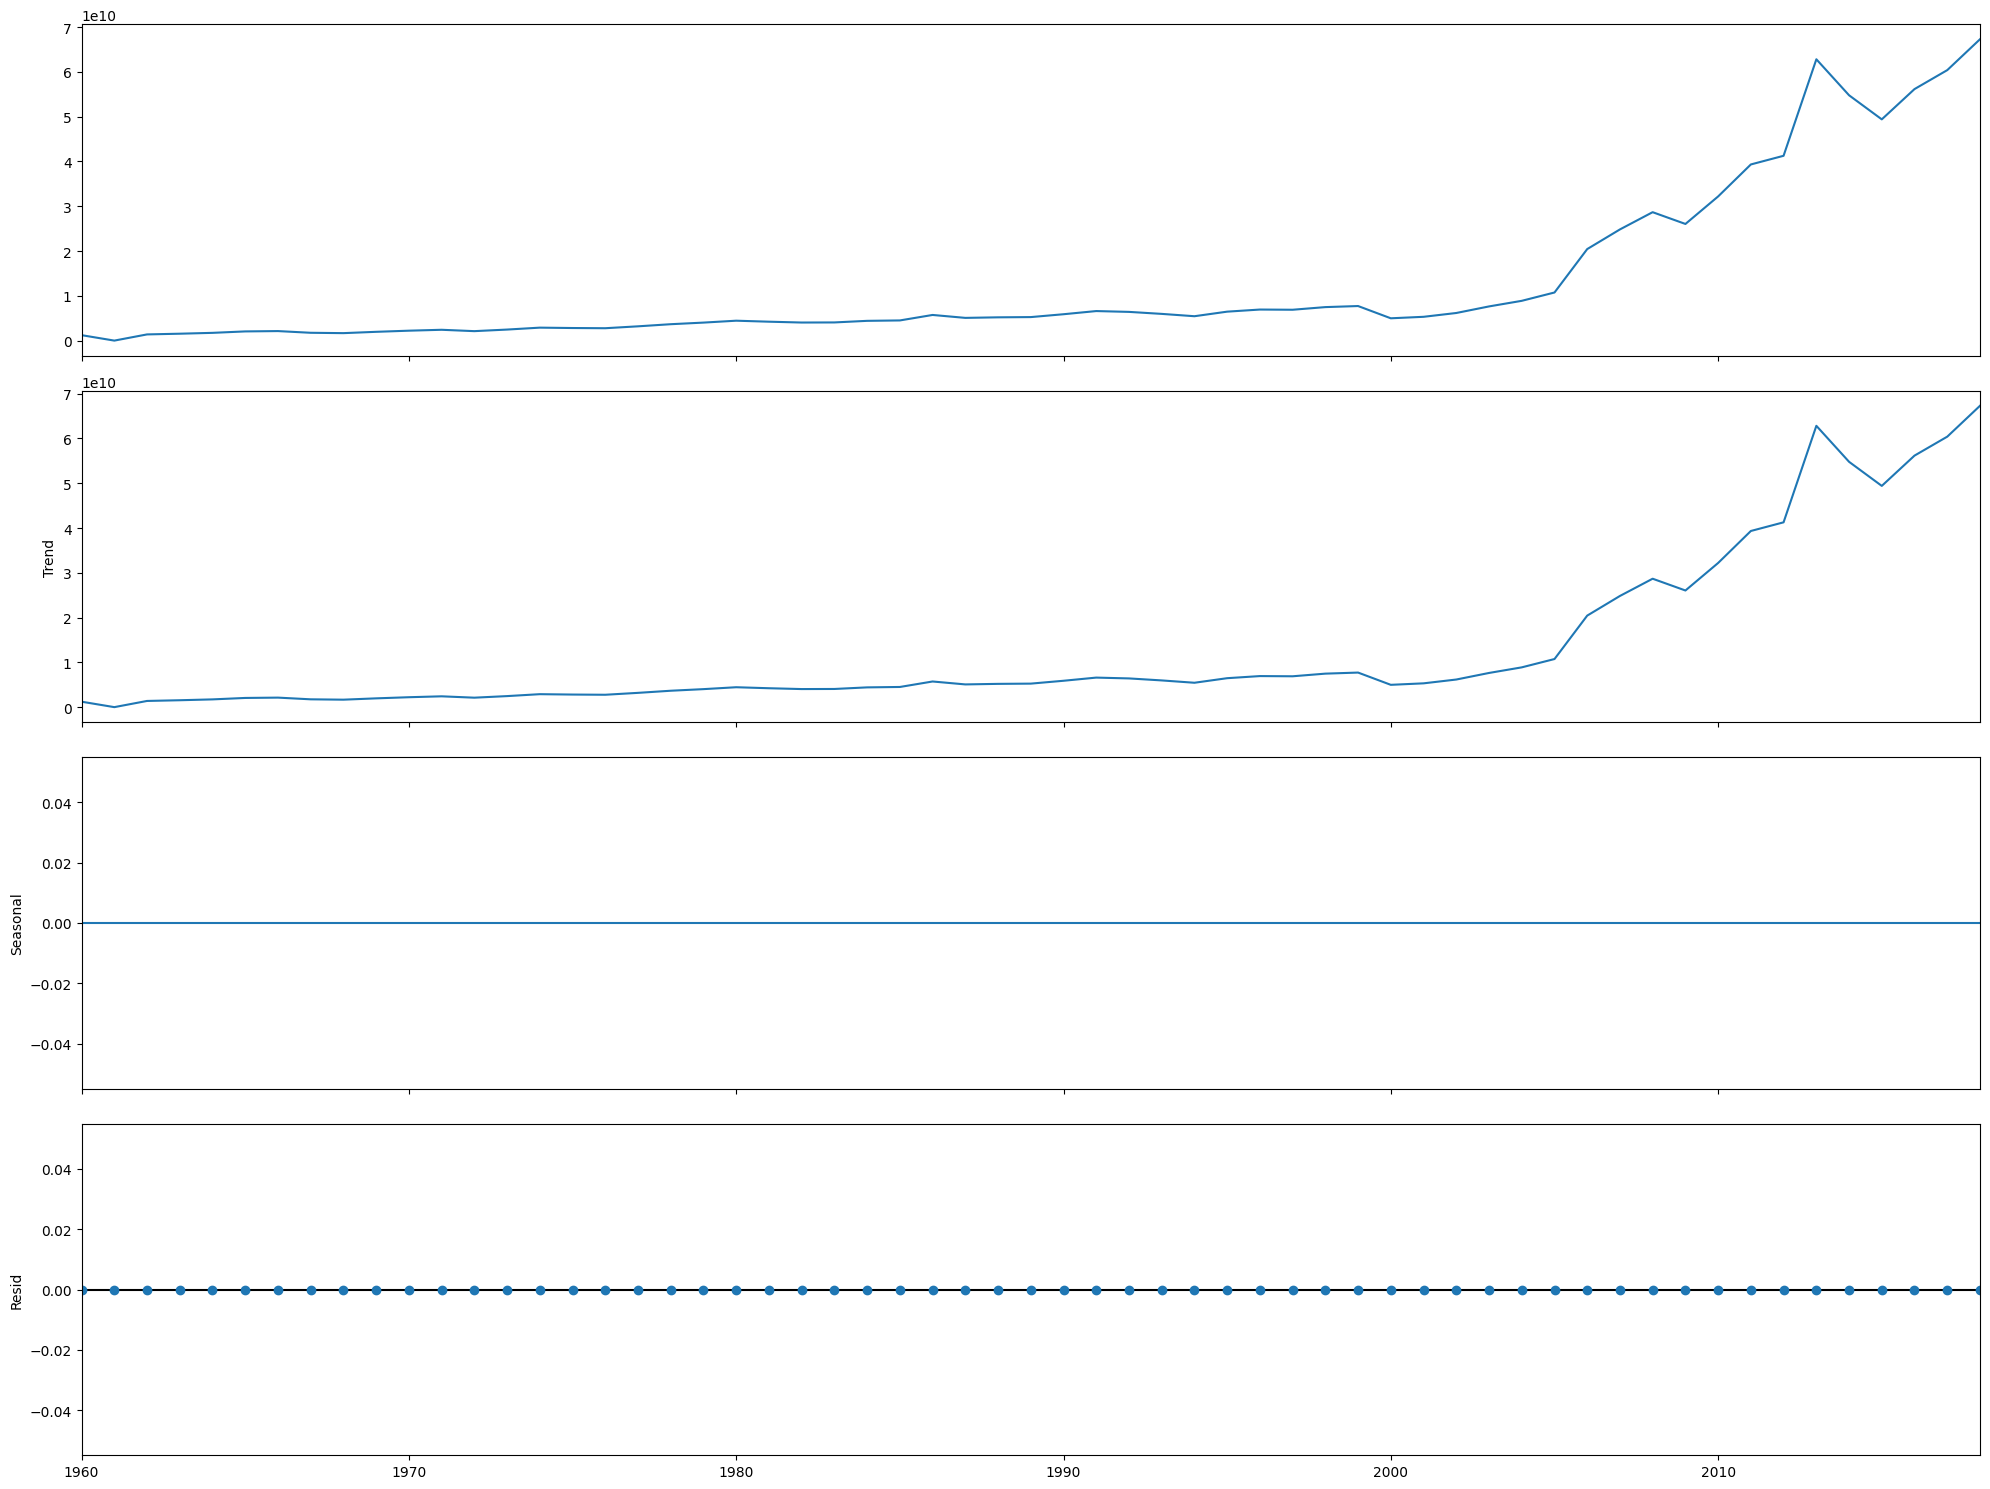

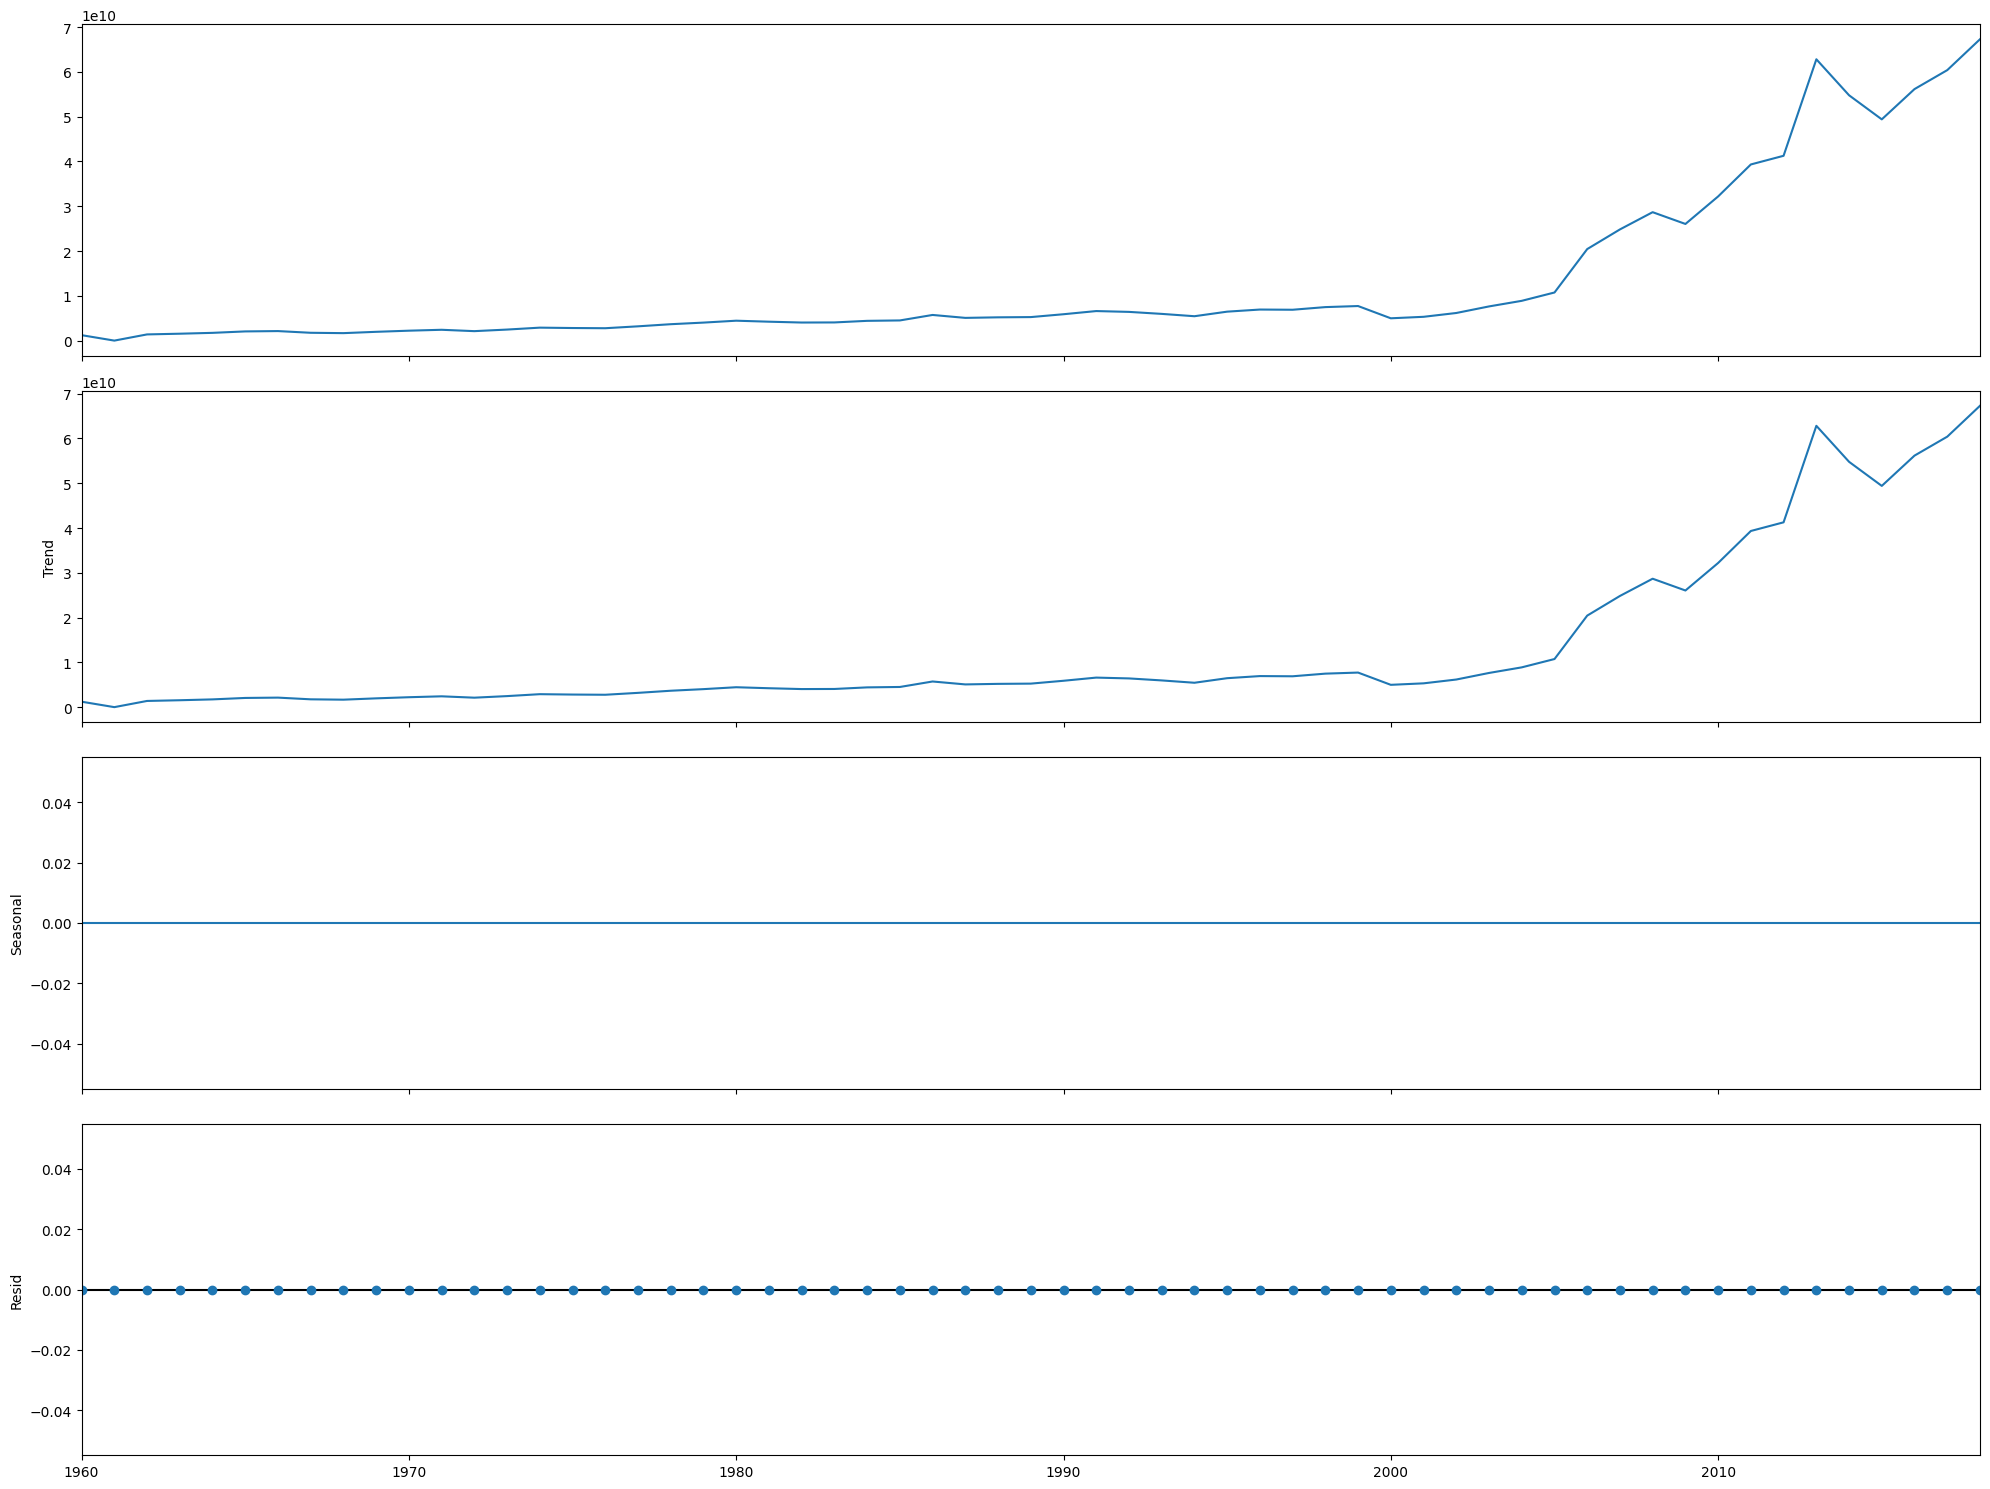

In [8]:
# исследуем данные на сезонность и тренд
plt.rcParams["figure.figsize"] = 20,15
decomp = seasonal_decompose(train_df, model='additive')
decomp.plot()

### По графикам можно сказать, что в данных прослеживается тренд, а вот сезонность и шум в данных отсутствуют.


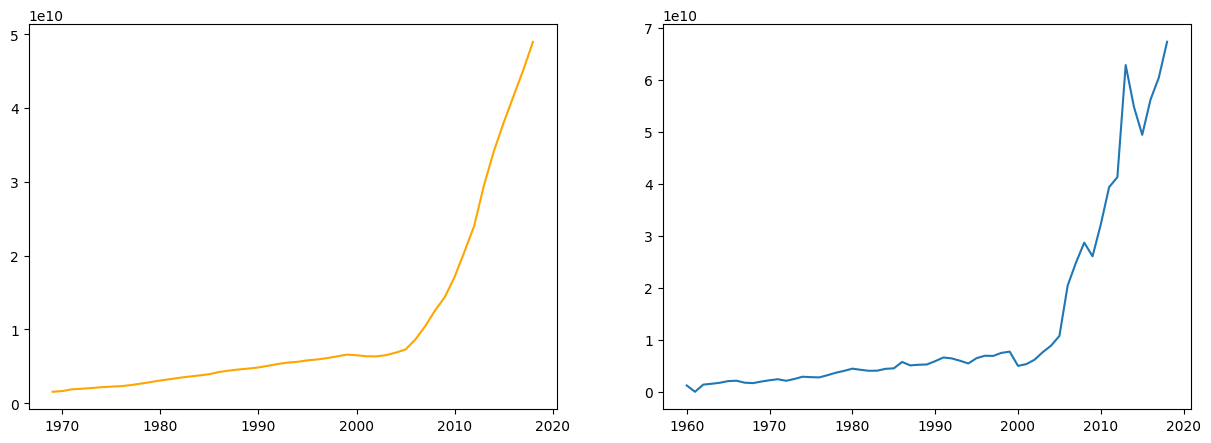

In [9]:
# строим график со скользящим средним и размером окна в 10 
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
ax[0].plot(train_df.rolling(window=10).mean(), color = 'orange')
ax[1].plot(train_df)

### На графике так же отчетливо прослеживается тренд

In [10]:
# проводим тесит на стационарность временного ряда

model = adfuller(train_df)
model

(0.6529066974885349,
 0.9888496277665572,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

### ряд не стационарен

In [11]:
# диффиринцируем временной ряд

train_df_diff_1 = train_df.diff().dropna()
#train_df_diff_1

In [12]:
# проводим тест на диффиринцируемом временном ряду 

adfuller(train_df_diff_1)

(-1.6702483038320777,
 0.446502932971389,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

### ряд остается не стационарным

In [13]:
# диффиринцируем второй раз
train_df_diff_2 = train_df_diff_1.diff().dropna()

In [14]:
# диффиринцируем третий раз
train_df_diff_3 = train_df_diff_2.diff().dropna()

In [15]:
# проводим тест Дики-Фуллера
adfuller(train_df_diff_3)

(-4.779623784828512,
 5.9483276402254376e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.481155659526)

### ряд стационарен, получаем интегрировныый времянной ряд 3 порядка.

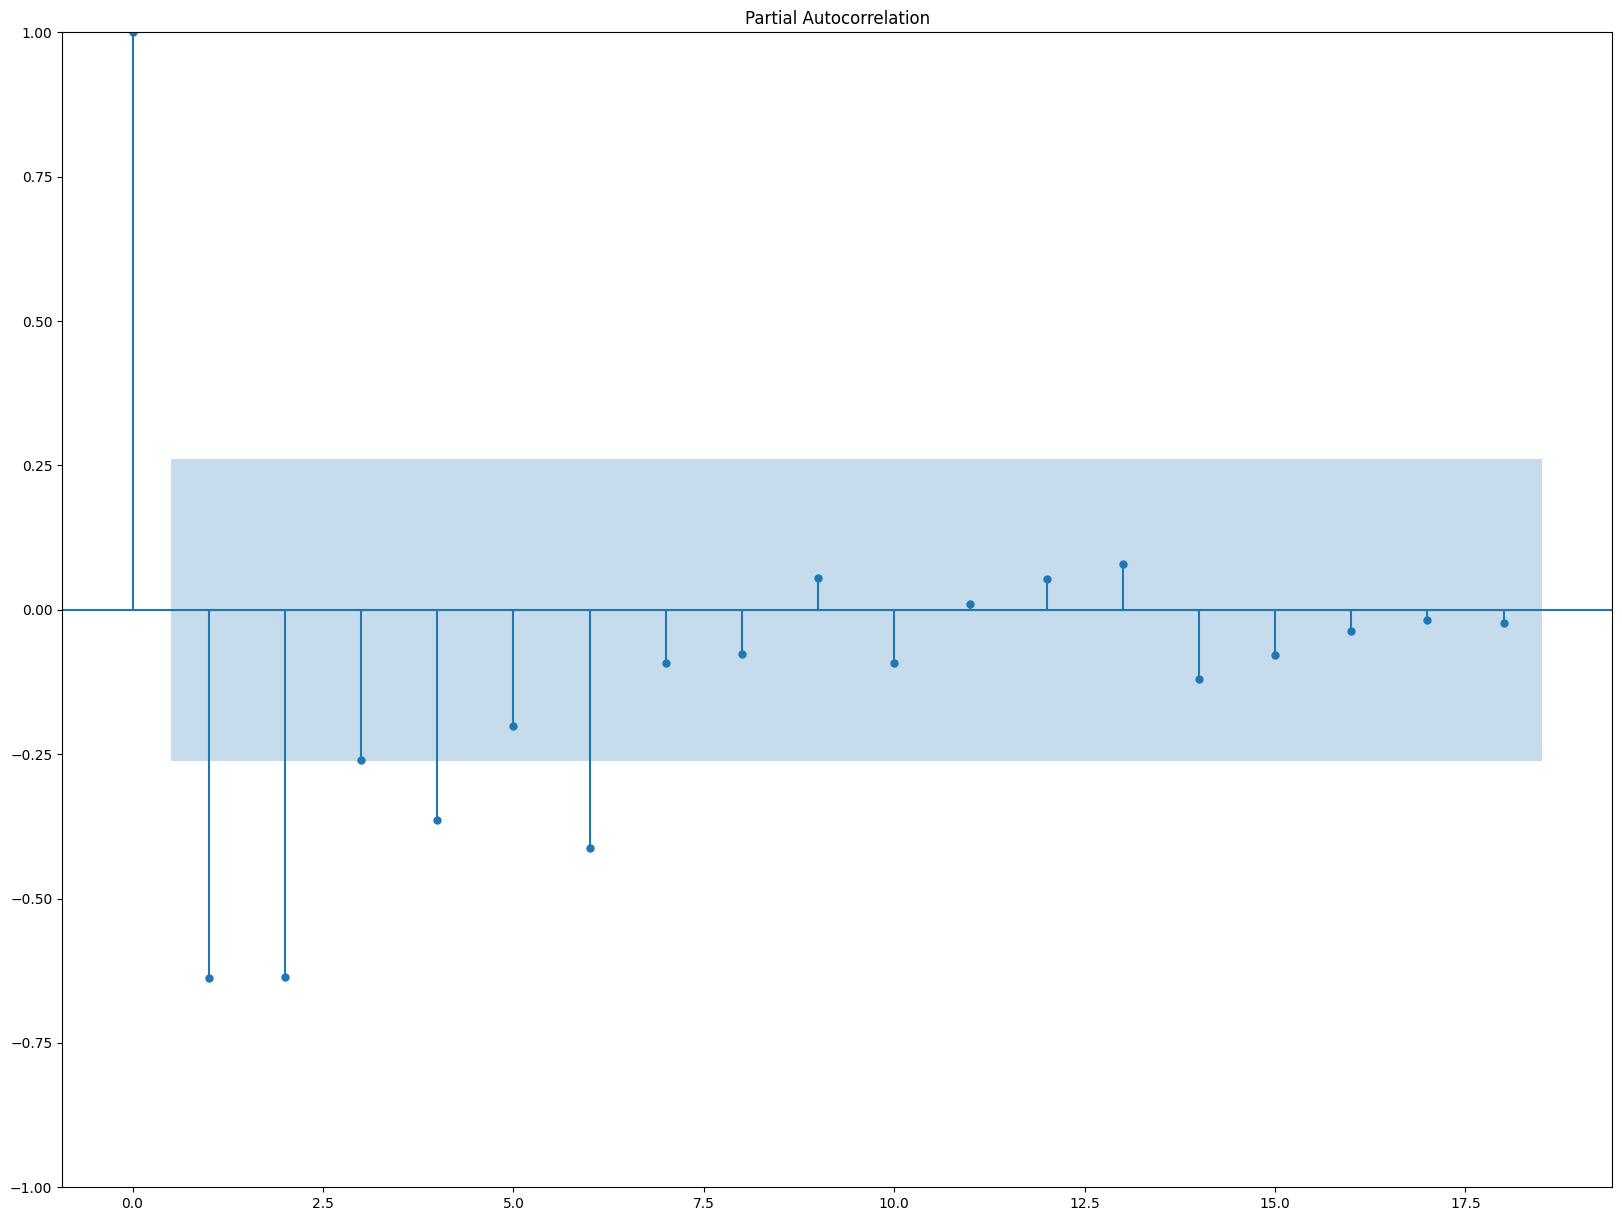

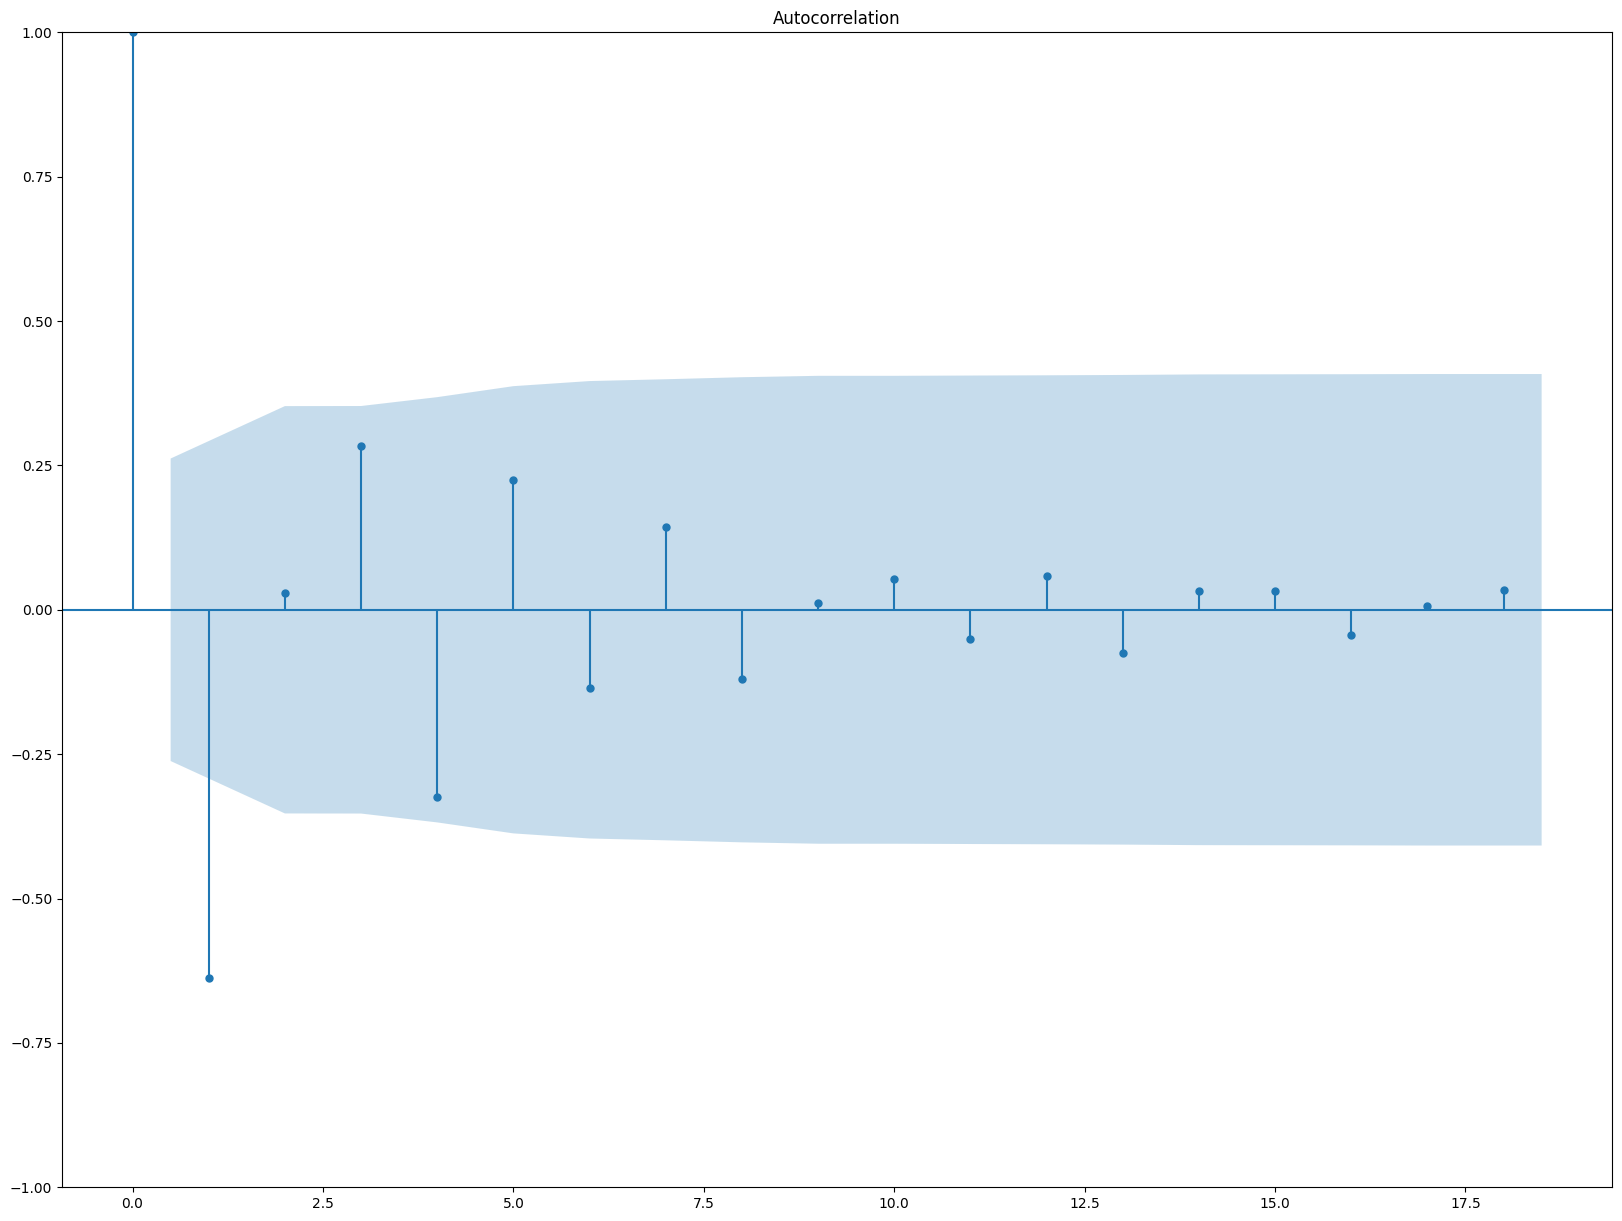

In [16]:
# визуализируем временной ряд на автокорреляцию и частичную автокорреляцию
pacf = plot_pacf(train_df_diff_3)
acf = plot_acf(train_df_diff_3)

### для значения p = 5, q = 2, d = 3

In [17]:
# передаем получившиеся параметры для построения модели ARIMA
model = SARIMAX(train_df, order=(2,3,1))
arima_model_fit = model.fit()
arima_model_fit.summary()

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 08 Oct 2024   AIC                           2659.231
Time:                        21:19:36   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

### выбираем модель ___ARIMA___, т.к сезонность в данных у нас отсутствует

In [18]:
# подбираем гиперпараметры для модели ARIMA
pmdarima = auto_arima(train_df,
                      max_p= 7, max_q=7, d = 3,
                      seasonal=False, trace= True,
                      max_D=3, max_P=7, max_Q=7,
                      error_action='ignore',
                      suppress_warnings= True,
                      stepwise= True)
pmdarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.02 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.450 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 08 Oct 2024   AIC                           2659.231
Time:                        21:19:37   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

### auto_arima показала более лучший результат, поэтому выбираем гиперпараметры из нее

In [19]:
# формируем новый DataFrame с предсказанными значениями и доверительного интервала в 95%
pred_df = pd.DataFrame(index = df.index)
pred_df['model_preds'] = arima_model_fit.predict(start=test_df.index[0], end= test_df.index[-1])
pred_df['spx'] = df['GDP (current US$)']
pred_df

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, 'lower'] =  forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, 'upper'] = forecast_df['upper GDP (current US$)']



In [20]:
pred_df

,model_preds,spx,lower,upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.368591e+10,6.833754e+10,6.269386e+10,8.467796e+10


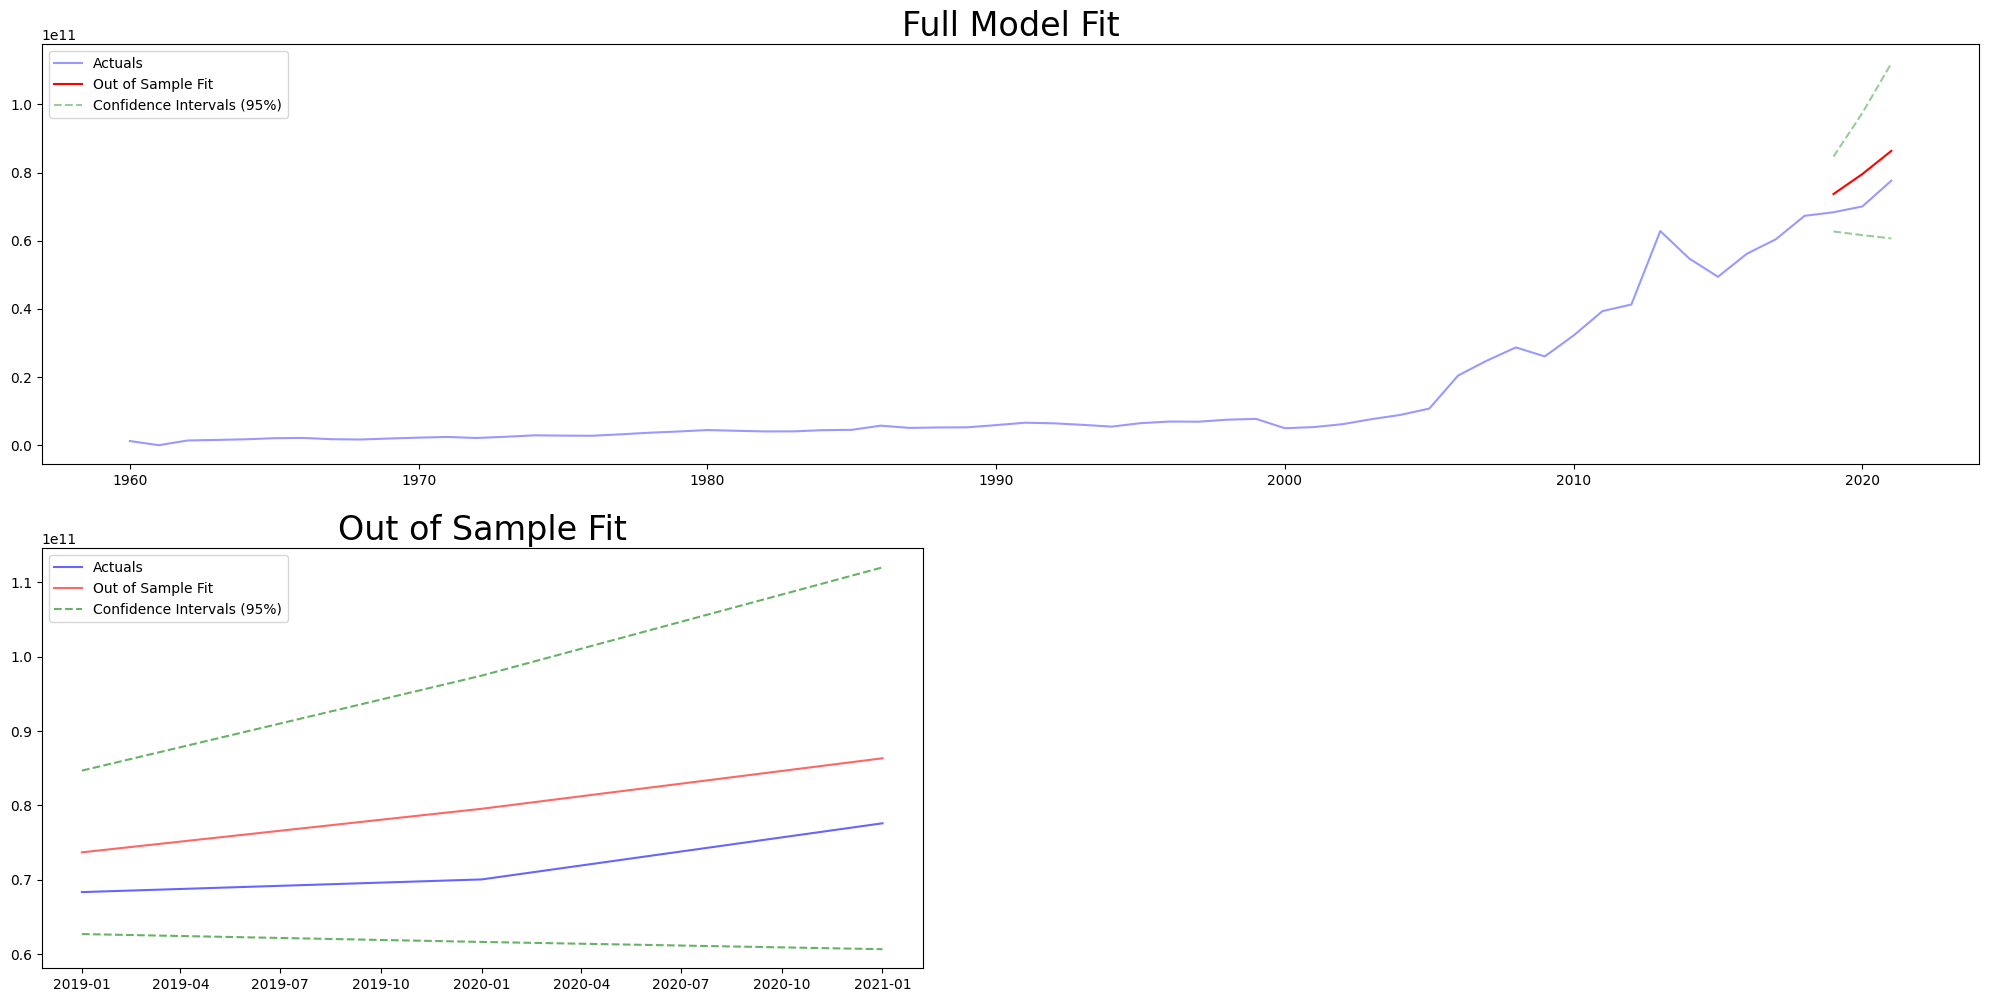

In [21]:
# Визуализируем полученный результат

plt.rcParams["figure.figsize"] = 25, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]['model_preds'],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]['model_preds'],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

### Из полученных графиков можно сделать вывод, что модель уловила тренд во времянном ряду.

In [22]:
# находим пропуски в датах
df.asfreq(freq='AS')
pd.set_option('display.max_rows', 100)
df.asfreq(freq='MS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1960-02-01,NaN
1960-03-01,NaN
1960-04-01,NaN
1960-05-01,NaN
...,...
2020-09-01,NaN
2020-10-01,NaN
2020-11-01,NaN


### Видим, что у нас наблюдения только за 1 число января каждого года.

In [23]:
# проверяем данные на наличие пропусков
df.isna().mean()*100

GDP (current US$)    0.0
dtype: float64

In [24]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)

In [25]:
df.isna().sum()

GDP (current US$)    1
dtype: int64

In [26]:
df['GDP (current US$)'][df['GDP (current US$)'].notna() == False]

year
1961-01-01   NaN
Name: GDP (current US$), dtype: float64

In [27]:
df_inter = df
df_inter['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')


In [28]:
df_inter_train = df_inter['GDP (current US$)'].loc[:'2018-01-01']
df_inter_test = df_inter['GDP (current US$)'].loc['2019-01-01':]

In [29]:
stats = adfuller(df_inter_train)
stats

(0.8030073326980129,
 0.9916845572455877,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

In [30]:
df_diff1 = df_inter_train.diff().dropna()
df_diff2 = df_diff1.diff().dropna()
df_diff3 = df_diff2.diff().dropna()


In [31]:
adfuller(df_diff3)

(-4.825603687304014,
 4.857318076800112e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.481155659526)

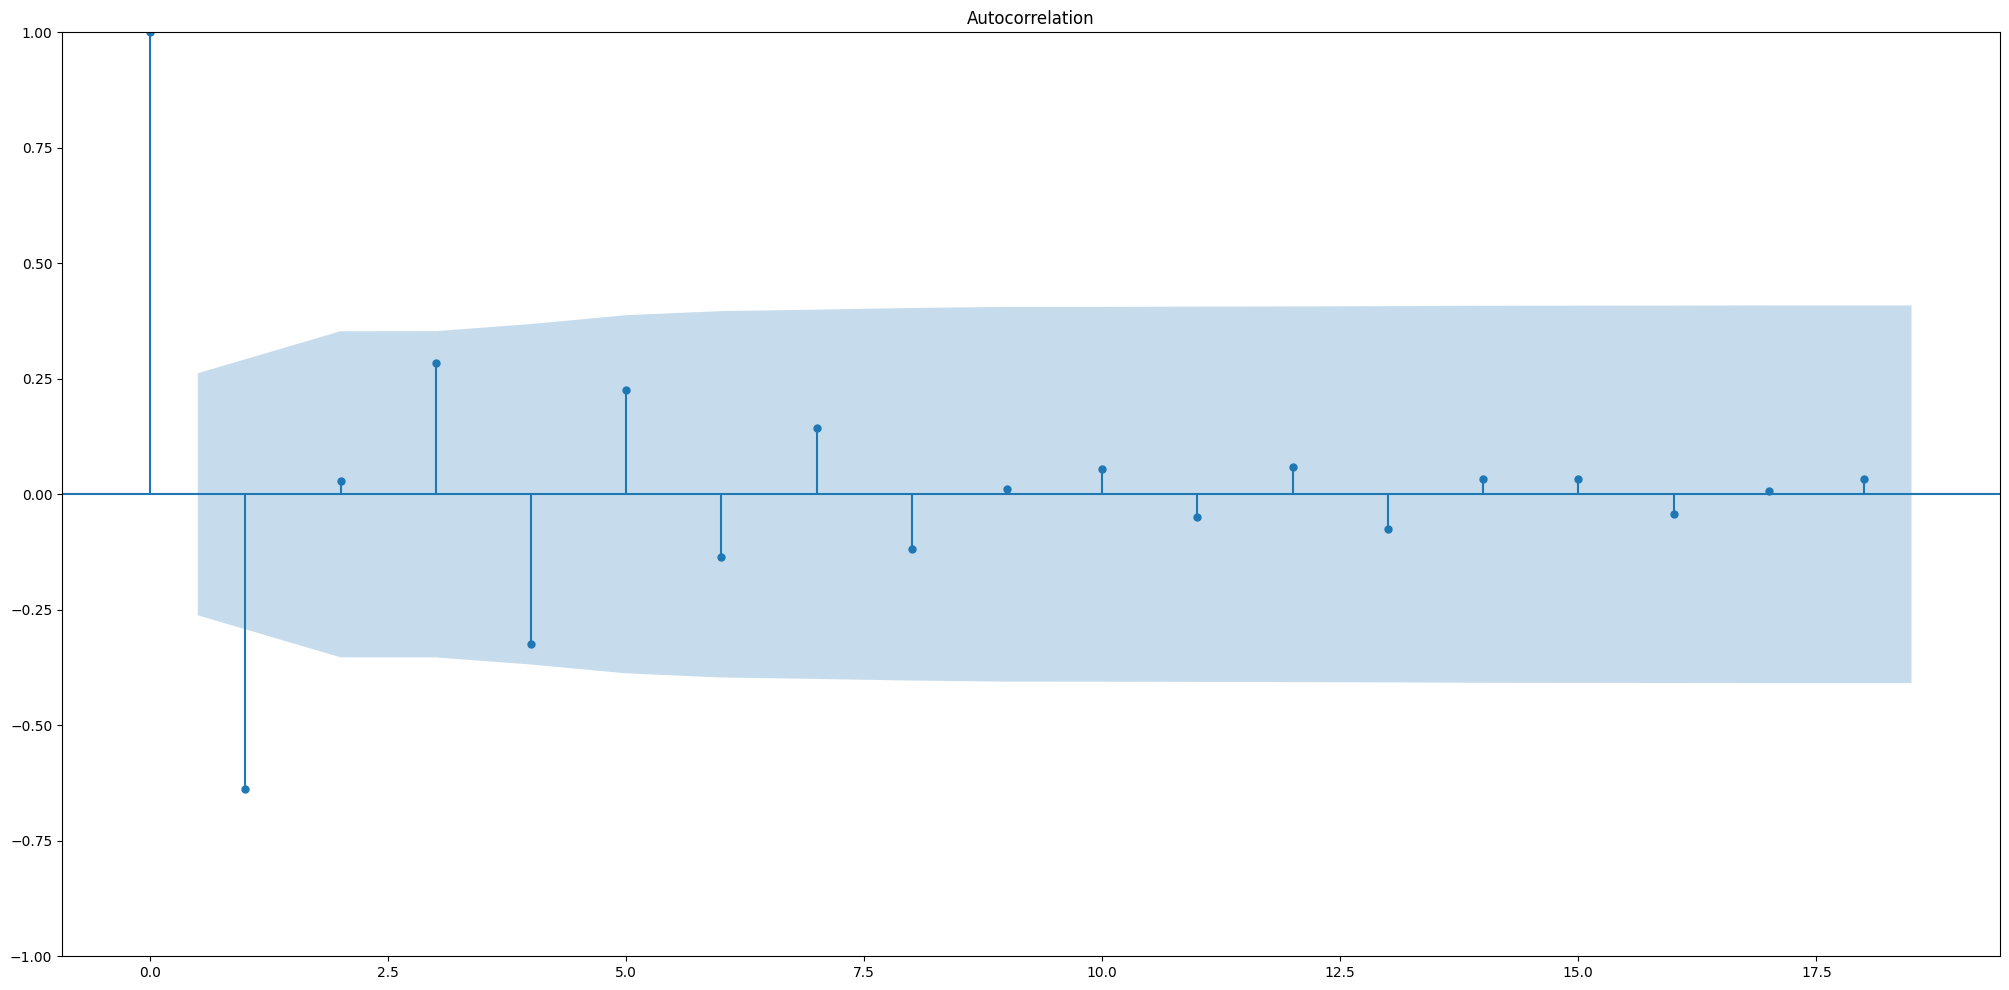

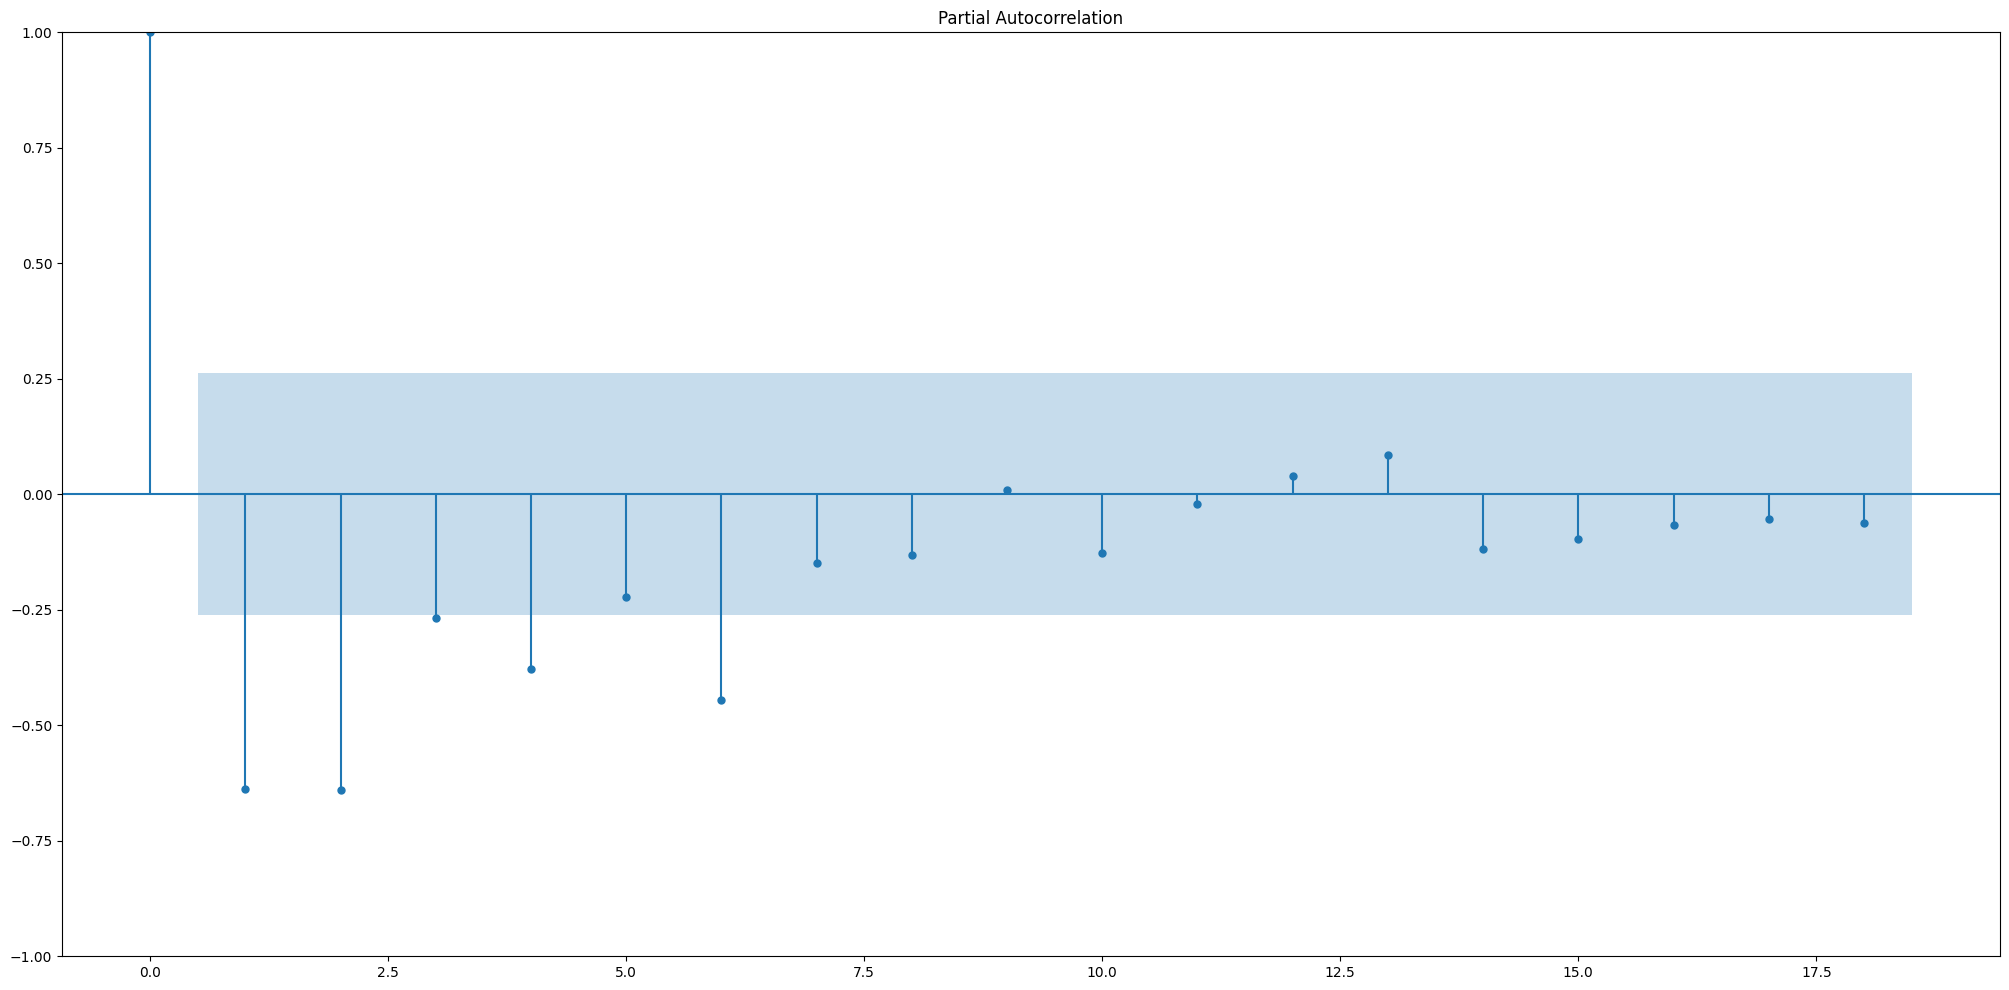

In [32]:
acf = plot_acf(df_diff3)
pacf = plot_pacf(df_diff3)

In [33]:
models = ARIMA(df_inter_train, order=(2,3,1))
model_fit = models.fit()
model_fit.summary()

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Tue, 08 Oct 2024   AIC                           2659.226
Time:                        21:19:38   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

In [34]:
pmdarima = auto_arima(df_inter_train,
                      max_p= 7, max_q=7, d = 3,
                      seasonal=False, trace= True,
                      max_D=3, max_P=7, max_Q=7,
                      error_action='ignore',
                      suppress_warnings= True,
                      stepwise= True)
pmdarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.02 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.413 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Tue, 08 Oct 2024   AIC                           2659.226
Time:                        21:19:38   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

### Ручной подбор c order(6,3,2) дал более меньший AIC (параметры подобраны с помощью автокорреляции),но график получился доверительного интервала получился таким, что модель не улавливает тренд, а вот подбор параметров с помощью auto_arima дал чуть более высокий показатель AIC, но на графике видно, что модель улавливает тренд.

In [35]:
pred_df1 = pd.DataFrame(index = df_inter.index)
pred_df1['model_preds'] = model_fit.predict(start=df_inter_test.index[0], end= df_inter_test.index[-1])
pred_df1['spx'] = df_inter['GDP (current US$)']
pred_df1

forecast = model_fit.get_forecast(len(df_inter_test.index))
forecast_df_iter = forecast.conf_int(alpha=0.05)

pred_df1.at[df_inter_test.index, 'lower'] =  forecast_df_iter['lower GDP (current US$)']
pred_df1.at[df_inter_test.index, 'upper'] = forecast_df_iter['upper GDP (current US$)']

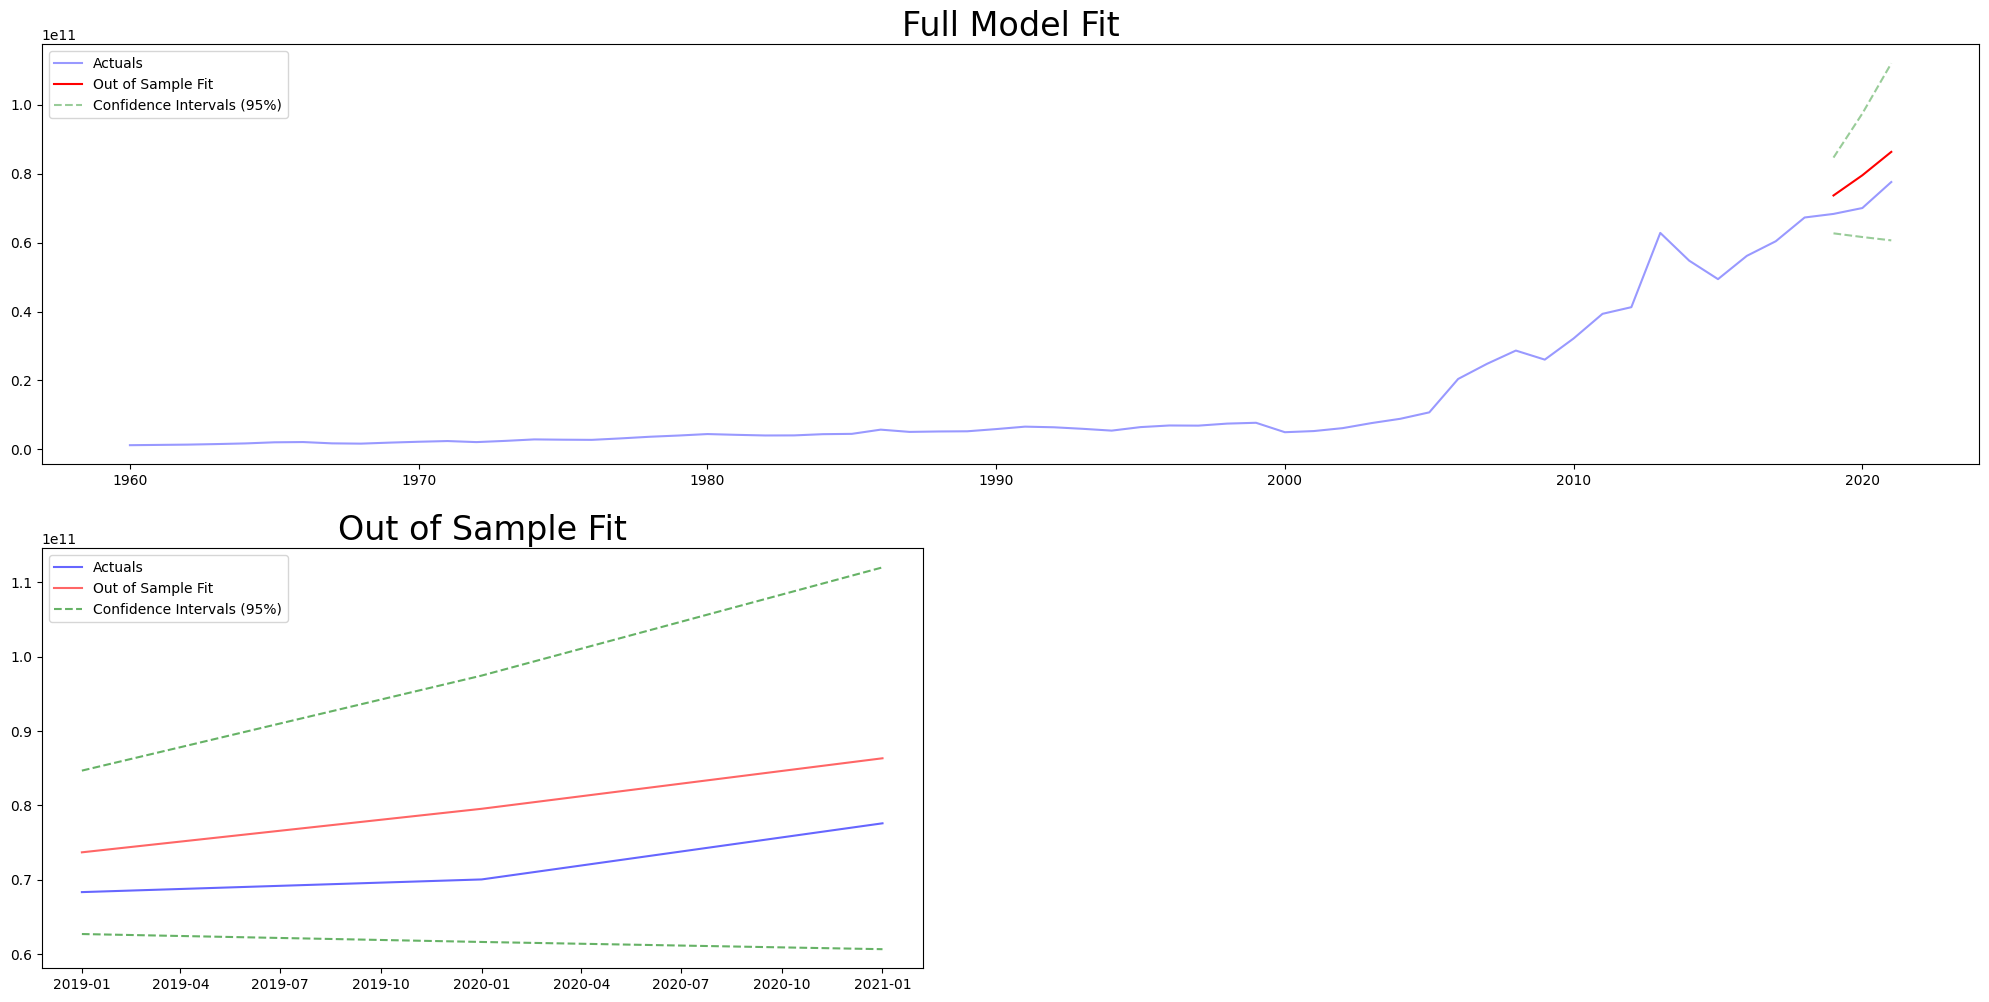

In [36]:
# Визуализируем полученный результат

plt.rcParams["figure.figsize"] = 25, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df1["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df1.loc[df_inter_test.index]['model_preds'],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df1.loc[df_inter_test.index]["lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df1.loc[df_inter_test.index]["upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df1.loc[df_inter_test.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df1.loc[df_inter_test.index]['model_preds'],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df1.loc[df_inter_test.index]["lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df1.loc[df_inter_test.index]["upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

### показатель  AIC в обоих случаях получился одинаковый, но если применить интерполяцию в более объемных выборках с большим кол-вом пропусков, то по моему мнению модель покажет более хорошии результаты.

In [37]:
from sklearn.model_selection import TimeSeriesSplit

In [38]:
split = TimeSeriesSplit(n_splits=3, test_size= 7)
train_test_groups = split.split(df)

for x , y in train_test_groups:
    print(x,y)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] [41 42 43 44 45 46 47]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] [48 49 50 51 52 53 54]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] [55 56 57 58 59 60 61]


In [39]:
df_inter['spx_vol'] = df_inter['GDP (current US$)'].pct_change(1).mul(100).abs()
df_inter.head(5)

,GDP (current US$),spx_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


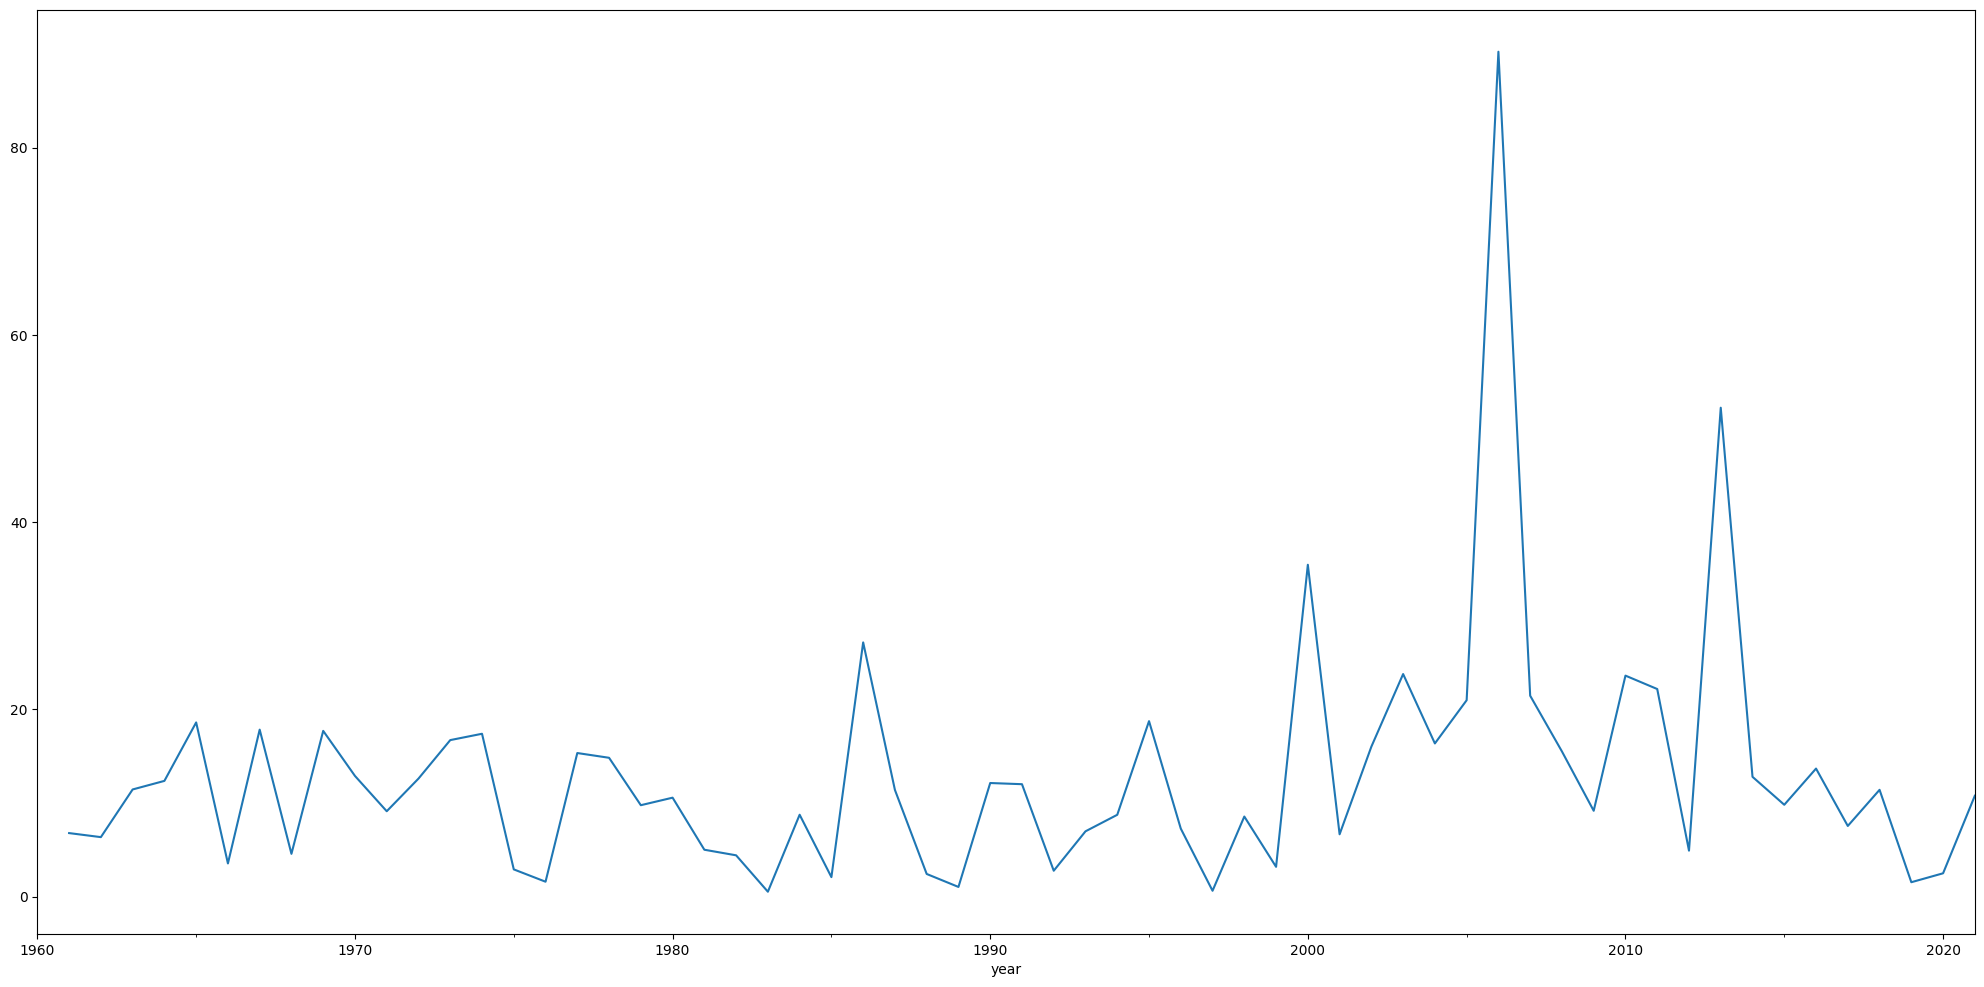

In [40]:
df_inter['spx_vol'].plot()
plt.show()

In [41]:
train_df_vol = df_inter.loc[:'2018-01-01']
test_df_vol = df_inter.loc['2019-01-01':]
train_df_vol.shape
test_df_vol.shape

(3, 2)

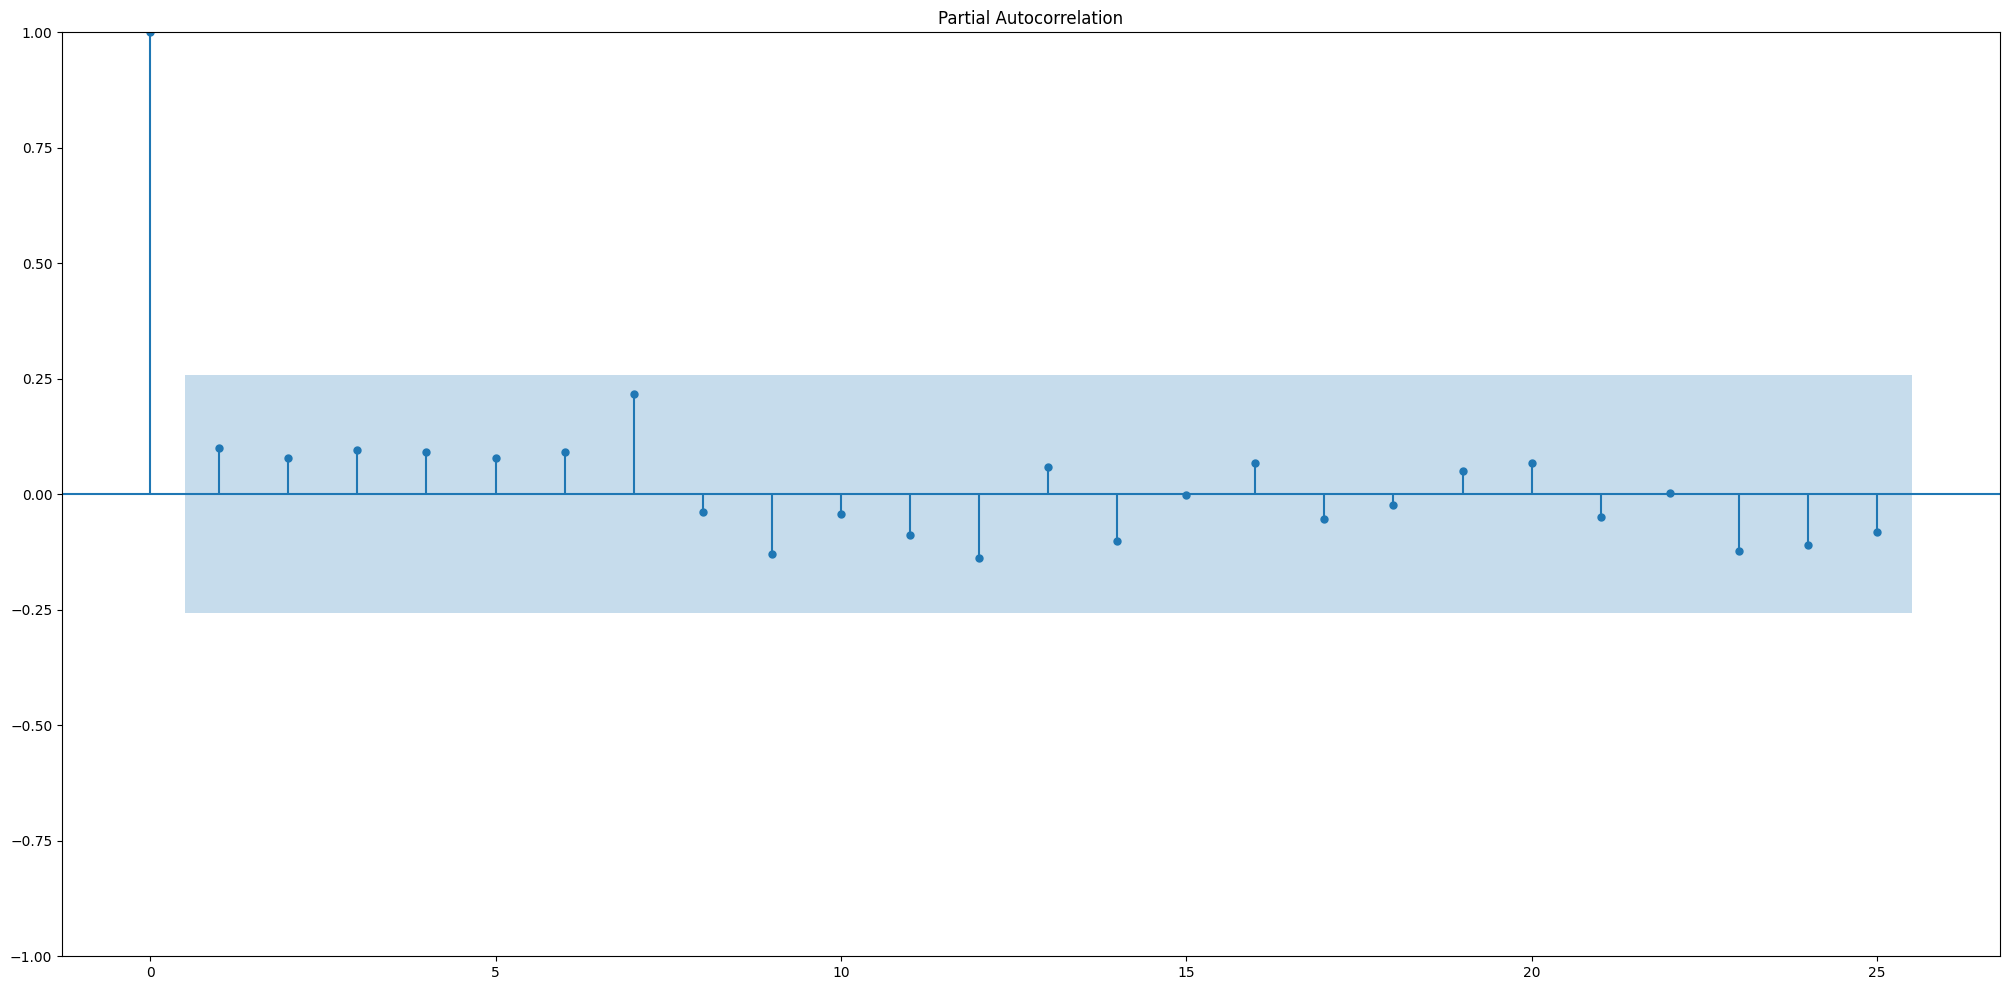

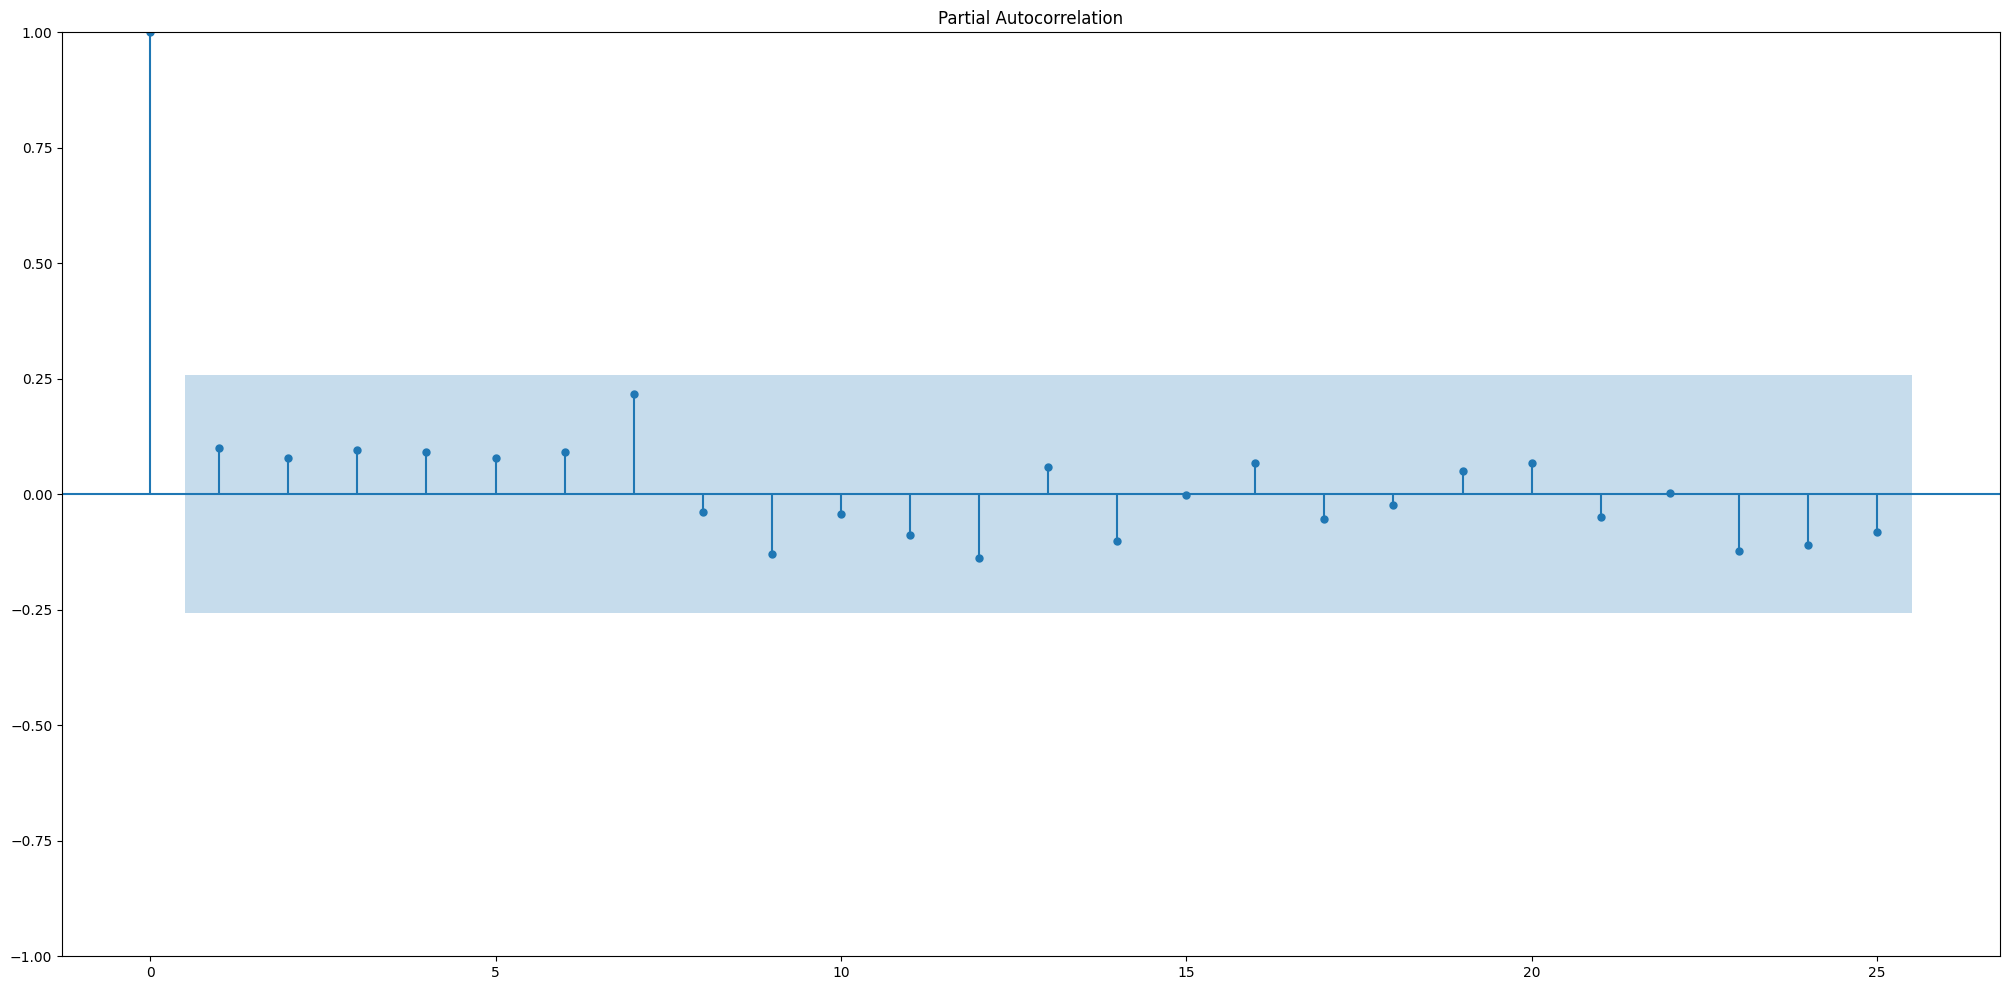

In [42]:
pacf = plot_pacf(train_df_vol['spx_vol'].iloc[1:], lags=25)
pacf

In [43]:
adfuller(train_df_vol.spx_vol[1:])


(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [44]:
from arch import arch_model

In [45]:
arch_df = pd.DataFrame(df_inter['spx_vol'].shift(1).loc[df_inter.index])
arch_df.loc[train_df_vol.index, "spx_vol"] = train_df_vol["spx_vol"].dropna()

In [56]:
model_arch = arch_model(arch_df['spx_vol'].dropna(), p = 7 , q = 7, vol = 'GARCH')
model_result = model_arch.fit(last_obs=test_df_vol.index[0], update_freq= 5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [57]:
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Tue, Oct 08 2024   Df Residuals:                       57
Time:                        21:20:48   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

In [58]:
predict_df = test_df_vol.copy()
predict_df['Prediction'] = model_result.forecast().residual_variance.loc[test_df_vol.index]

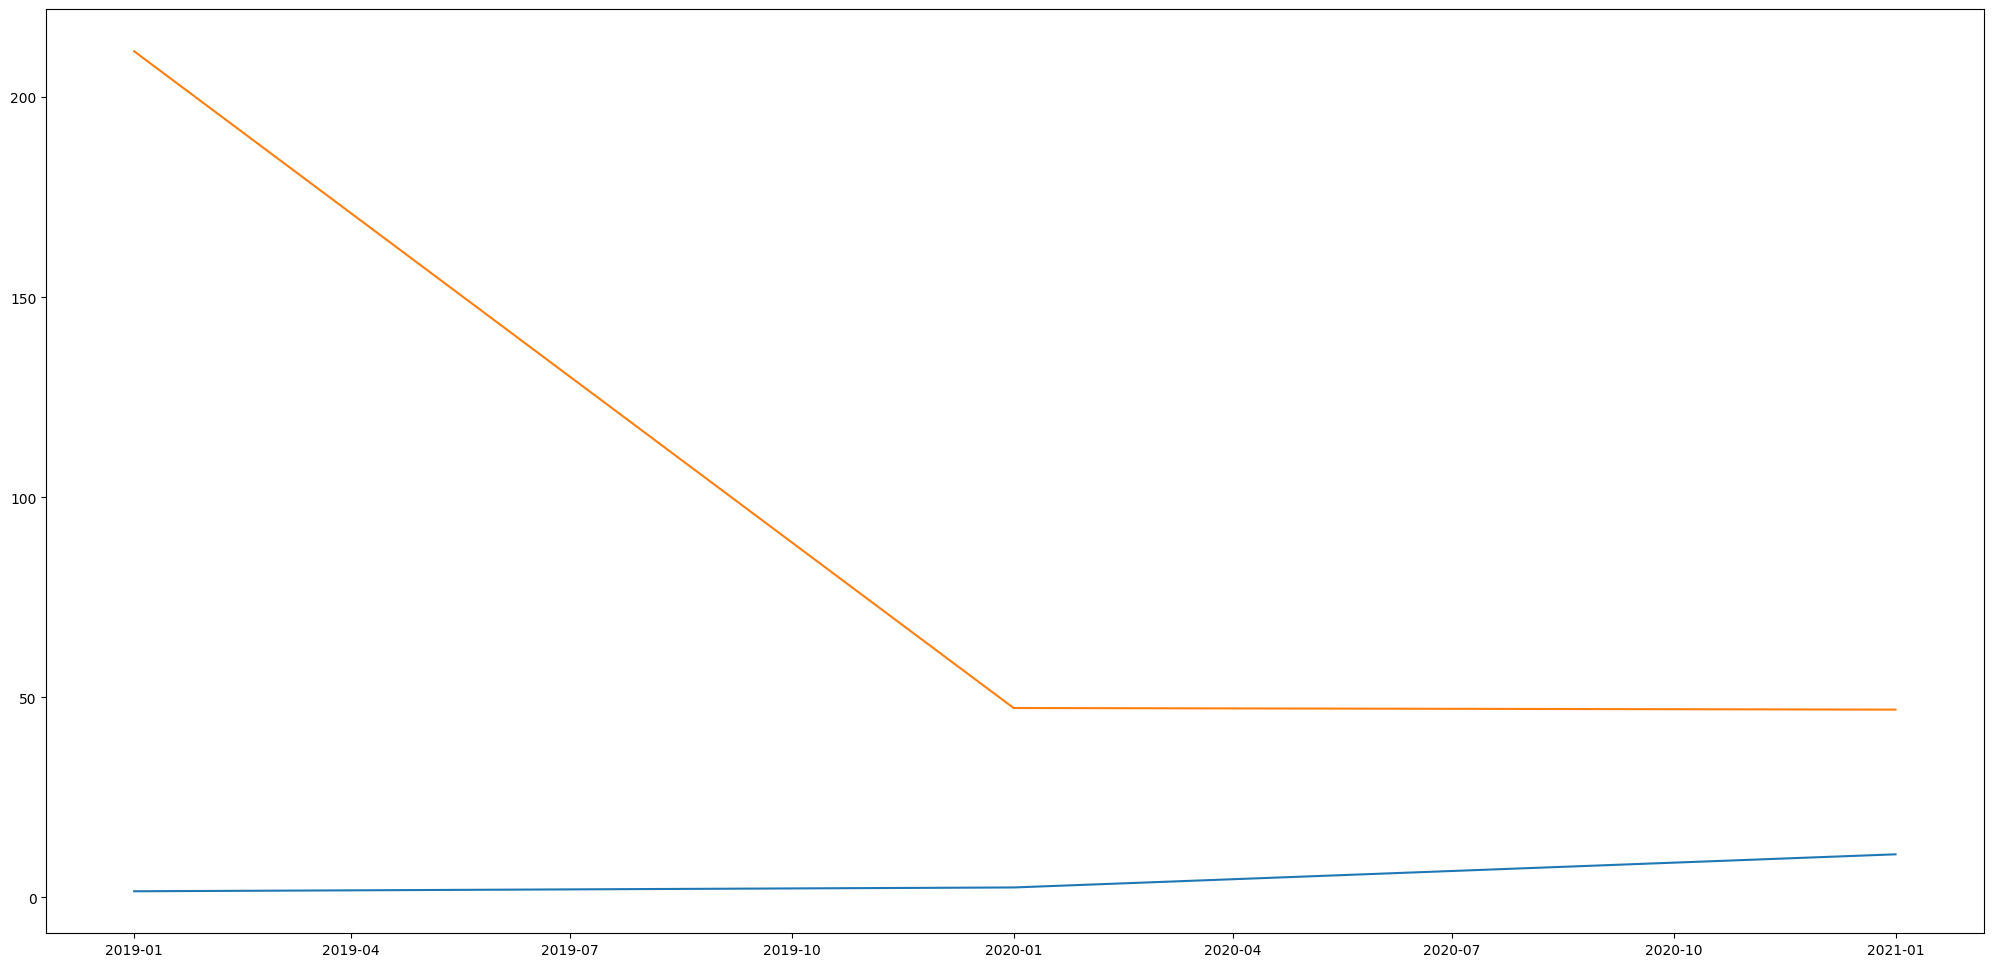

In [59]:
plt.plot(predict_df['spx_vol'].abs())
plt.plot(predict_df['Prediction'])

In [60]:
predict_df

,GDP (current US$),spx_vol,Prediction
year,,,
2019-01-01,6.833754e+10,1.542746,211.494331
2020-01-01,7.004320e+10,2.495937,47.349109
2021-01-01,7.759428e+10,10.780603,46.946471


In [61]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predict_df["spx_vol"].abs(), predict_df['Prediction']
)

15799.81505534383

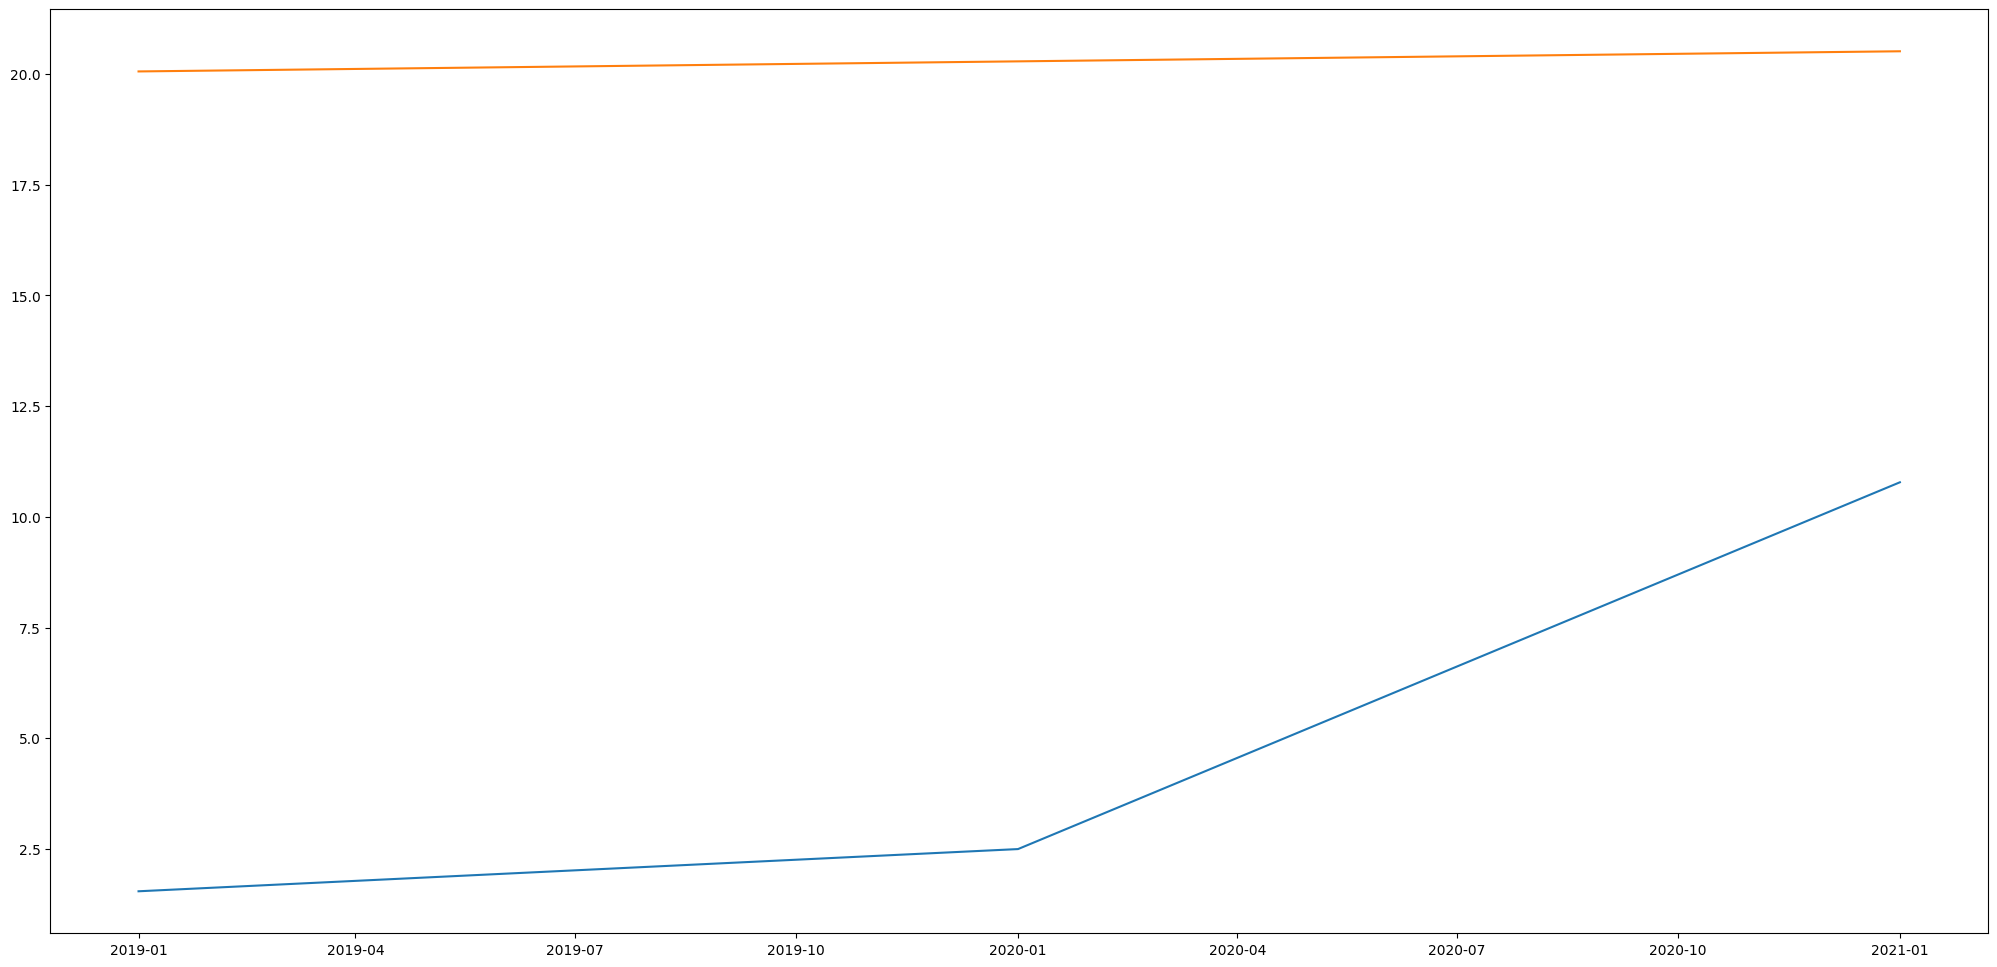

In [62]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df_inter["spx_vol"].shape[0]))[
    : train_df_vol.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df_inter["spx_vol"].shape[0]))[
    train_df_vol.shape[0] :
].fillna(0)
y_train = train_df_vol["spx_vol"].fillna(0)
y_test = test_df_vol["spx_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

### Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. В примере из скринкаста был противоположный результат, так как имелось больше данных и в обучающей выборке были случаи и возрастания, и убывания дисперсии, что удалось уловить модели.